In [2]:
!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user

  Cloning https://github.com/desi-bgs/bgs-cmxsv.git to /tmp/pip-req-build-89lbzv4j
  Running command git clone -q https://github.com/desi-bgs/bgs-cmxsv.git /tmp/pip-req-build-89lbzv4j
  Created wheel for bgs-sv: filename=bgs_sv-0.0-py3-none-any.whl size=1087771 sha256=71ded531996c3298bc69f875a41cbce302c2099458f440d41340e148579fb8f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-onw0o82x/wheels/c5/7b/33/3fa8f7338087a37e7ad7a1378e08d97458e5dbab577a10268f
Successfully built bgs-sv
  Attempting uninstall: bgs-sv
    Found existing installation: bgs-sv 0.0
    Uninstalling bgs-sv-0.0:
      Successfully uninstalled bgs-sv-0.0


In [3]:
import numpy as np 
import astropy.table as atable
import matplotlib.pyplot as plt

from bgs_sv import sv1

# read single exposures from Blanc reduction

In [2]:
exps = sv1.blanc_nexp1_exposures()

In [3]:
# lets only keep the nightly exposures where we have a corresponding 
# deep exposure that we can use as the truth table
deep_exp = sv1.blanc_deep_exposures()

keep = np.zeros(len(exps)).astype(bool)
for i in range(len(exps)): 
    if exps[i]['TILEID'] in deep_exp['TILEID']: 
        keep[i] = True
print('%i exposures with corresponding deep exposures' % np.sum(keep))

175 exposures with corresponding deep exposures


In [19]:
r_depth_ebvair = 180
d_r_depth_ebvair = 20
close_to_nominal = np.abs(exps['R_DEPTH_EBVAIR'] - r_depth_ebvair) < d_r_depth_ebvair
isbgs = (exps['TARGETS'] == 'BGS+MWS')

bgs_exps = exps[isbgs & keep & close_to_nominal]
print(bgs_exps['TILEID', 'NIGHT', 'EXPID'])
print('%i exposures that have deep and are close to nominal' % len(bgs_exps))

TILEID  NIGHT   EXPID
------ -------- -----
 80614 20201218 68686
 80616 20201219 68790
 80617 20201220 69024
 80617 20201220 69026
 80612 20201221 69223
 80613 20201221 69225
 80613 20201221 69227
 80613 20201221 69228
 80613 20201221 69230
9 exposures that have deep and are close to nominal


# $z$ success rate
To quantify $z$ success rate, we use the DEEP exposures as the truth table. 
For each tile, we only consider BGS SV targets that meet the following criteria from the DEEP exposure: 
- ZWARN = 0
- DELTACHI2 > 40
- SPECTYPE != 'STAR'
- 0. < Z < 0.6
- ZERR < 0.0005 (1 + Z)
Any targets that do not meet these criteria are considered targeting issues. 

Out of these targets we determine redshift success for SINGLE expsoures if the following criteria are met: 
- ZWARN = 0
- DELTACHI2 > 40
- SPECTYPE != 'STAR'
- 0. < Z < 0.6
- ZERR < 0.0005 (1 + Z)
- |Z - Z_DEEP| / (1+Z_DEEP) < 0.003  where Z_DEEP is the redrock redshit for DEEP exposure

In [20]:
def zsuccess_rate(prop, zsuccess_cond, range=None, nbins=20, bin_min=2):
    ''' measure the redshift success rate along with property `prop`

    :params prop: 
        array of properties (i.e. Legacy r-band magnitude) 

    :params zsuccess_cond:
        boolean array indicating redshift success 

    :params range: (default: None) 
        range of the `prop` 

    :params nbins: (default: 20) 
        number of bins to divide `prop` by 
    
    :params bin_min: (default: 2)  
        minimum number of objects in bin to exlcude it 

    :return wmean: 
        weighted mean of `prop` in the bins 

    :return e1: 
        redshift success rate in the bins

    :return ee1: 
        simple poisson error on the success rate
    '''
    h0, bins = np.histogram(prop, bins=nbins, range=range)
    hv, _ = np.histogram(prop, bins=bins, weights=prop)
    h1, _ = np.histogram(prop[zsuccess_cond], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    wmean = hv / h0 # weighted mean 
    rate = h1.astype("float") / (h0.astype('float') + (h0==0))
    e_rate = np.sqrt(rate * (1 - rate)) / np.sqrt(h0.astype('float') + (h0 == 0))
    return wmean, rate, e_rate

In [21]:
def get_exp_zsuccess(tileid, night, expid): 
    ''' get redshift success rate for given exposure
    '''
    # get redrock output for DEEP exposure for BGS_ANY targets
    _zbest_deep = sv1.get_zbest(tileid, 'deep', targetclass='all')
    
    crit_zwarn = (_zbest_deep['ZWARN'] == 0)
    crit_dchi2 = (_zbest_deep['DELTACHI2']  > 40.) 
    crit_stype = (_zbest_deep['SPECTYPE'] != "STAR") # only galaxy spectra
    crit_z_lim = (_zbest_deep['Z'] > 0.0) & (_zbest_deep['Z'] < 0.6) # rough BGS redshift limit
    crit_z_err = (_zbest_deep['ZERR'] < (0.0005 * (1. + _zbest_deep['Z'])))
    
    truth_table = crit_dchi2 & crit_stype & crit_z_lim & crit_z_err
    zbest_deep = _zbest_deep[truth_table]['TARGETID', 'Z']
    # redrock redshifts from DEEP exposure will be used as true redshifts
    zbest_deep.rename_column('Z', 'Z_TRUE')
    
    # get redrock output for SINGLE exposure for BGS_ANY targets
    zbest_exp = sv1.get_zbest(tileid, night, expid=expid, targetclass='all')

    # only keep targets that are in the deep
    zbest_exp = atable.join(zbest_deep, zbest_exp, keys='TARGETID', join_type='inner')
    
    crit_zwarn = (zbest_exp['ZWARN'] == 0)
    crit_dchi2 = (zbest_exp['DELTACHI2']  > 40.) 
    crit_stype = (zbest_exp['SPECTYPE'] != "STAR") # only galaxy spectra
    crit_z_lim = (zbest_exp['Z'] > 0.0) & (zbest_exp['Z'] < 0.6) # rough BGS redshift limit
    crit_z_err = (zbest_exp['ZERR'] < (0.0005 * (1. + zbest_exp['Z'])))
    
    dz_1pz = np.abs(zbest_exp['Z_TRUE'] - zbest_exp['Z']) / (1. + zbest_exp['Z_TRUE'])
    crit_ztrue = (dz_1pz < 0.003)

    # combine all criteria
    zsuccess = crit_zwarn & crit_dchi2 & crit_stype & crit_z_lim & crit_z_err & crit_ztrue
    return zbest_exp, zsuccess

In [25]:
g_mags, r_mags, z_mags, w1_mags, w2_mags, r_fibmags, zss = [], [], [], [], [], [], []
for rdepth, tileid, night, expid in zip(bgs_exps['R_DEPTH_EBVAIR'], bgs_exps['TILEID'], bgs_exps['NIGHT'], bgs_exps['EXPID']):
    _zbest, _zs = get_exp_zsuccess(tileid, night, expid)
    g_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_G'])))
    r_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_R'])))
    z_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_Z'])))
    w1_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_W1'])))
    w2_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_W2'])))
    r_fibmags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FIBERFLUX_R'])))
    zss.append(_zs)
    
g_mags = np.concatenate(g_mags)
r_mags = np.concatenate(r_mags)    
z_mags = np.concatenate(z_mags)
w1_mags = np.concatenate(w1_mags)
w2_mags = np.concatenate(w2_mags)
r_fibmags = np.concatenate(r_fibmags)
zss = np.array(np.concatenate(zss))

<ipython-input-25-282238ad239f>:6: RuntimeWarning: divide by zero encountered in log10
  z_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_Z'])))
<ipython-input-25-282238ad239f>:7: RuntimeWarning: invalid value encountered in log10
  w1_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_W1'])))
<ipython-input-25-282238ad239f>:8: RuntimeWarning: invalid value encountered in log10
  w2_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_W2'])))
<ipython-input-25-282238ad239f>:4: RuntimeWarning: divide by zero encountered in log10
  g_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_G'])))
<ipython-input-25-282238ad239f>:6: RuntimeWarning: invalid value encountered in log10
  z_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_Z'])))
<ipython-input-25-282238ad239f>:4: RuntimeWarning: invalid value encountered in log10
  g_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_G'])))


# overall redshift success rate

Text(0, 0.5, '$z$ success rate')

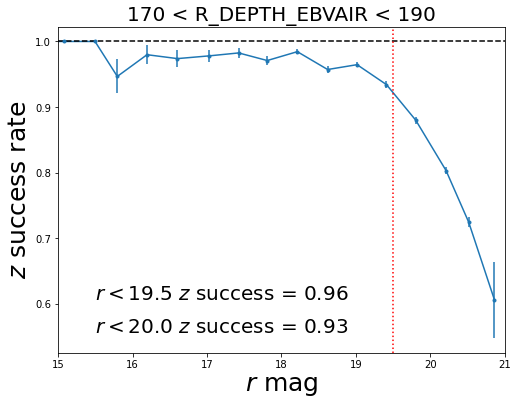

In [26]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
r_mid, zs, zs_err = zsuccess_rate(r_mags, zss, range=(14, 22), nbins=20)
sub.errorbar(r_mid, zs, yerr=zs_err, fmt='.C0')
sub.plot(r_mid, zs, c='C0')
sub.axhline(1., linestyle='--', color='k')

sub.text(15.5, 0.6, '$r < 19.5$ $z$ success = %.2f' % (np.sum(zss[r_mags < 19.5])/np.sum(r_mags < 19.5)), ha='left', va='bottom', fontsize=20) 
sub.text(15.5, 0.55, '$r < 20.0$ $z$ success = %.2f' % (np.sum(zss[r_mags < 20.0])/np.sum(r_mags < 20.0)), ha='left', va='bottom', fontsize=20) 

sub.set_title("%.f < R_DEPTH_EBVAIR < %.f" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)
sub.axvline(19.5, c='r', ls=':')
sub.set_xlabel('$r$ mag', fontsize=25)
sub.set_xlim(15, 21)
sub.set_ylabel('$z$ success rate', fontsize=25)

Text(0, 0.5, '$z$ success rate')

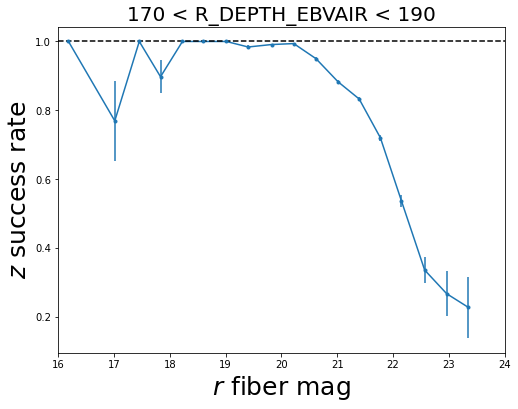

In [24]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
r_mid, zs, zs_err = zsuccess_rate(r_fibmags, zss, range=(16, 24), nbins=20)
sub.errorbar(r_mid, zs, yerr=zs_err, fmt='.C0')
sub.plot(r_mid, zs, c='C0')
sub.axhline(1., linestyle='--', color='k')
sub.set_title("%.f < R_DEPTH_EBVAIR < %.f" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)
sub.set_xlabel('$r$ fiber mag', fontsize=25)
sub.set_xlim(16, 24)
sub.set_ylabel('$z$ success rate', fontsize=25)

Text(0, 0.5, '$z$ success rate')

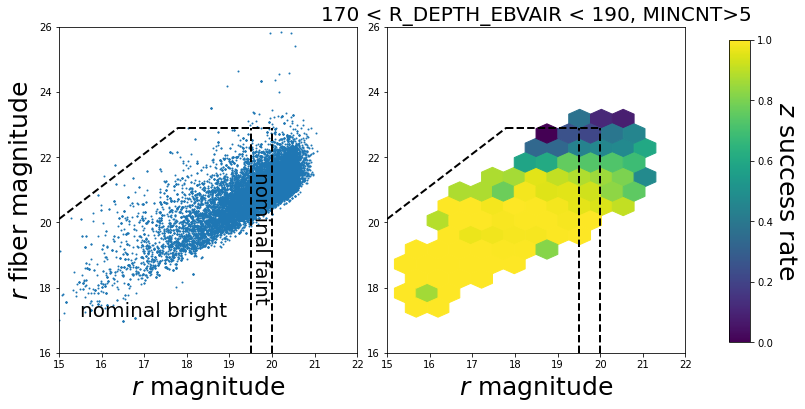

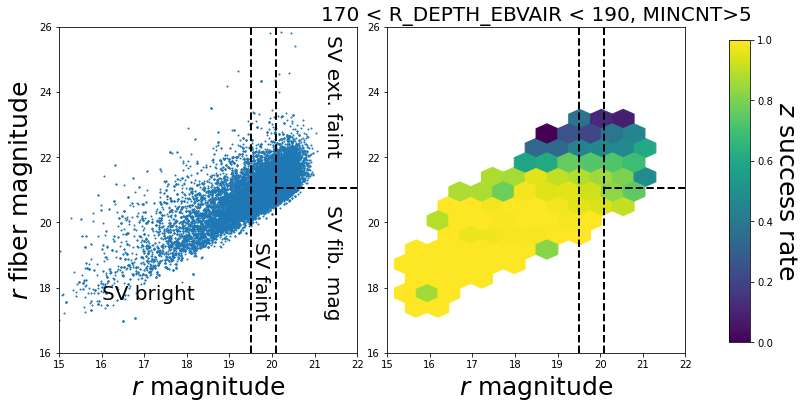

In [9]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(r_mags, r_fibmags, c='C0', s=1)
sub.plot([15, 17.8], [20.1, 22.9], c='k', ls='--', lw=2)
sub.plot([17.8, 20.], [22.9, 22.9], c='k', ls='--', lw=2)
sub.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=2)
sub.plot([20., 20.], [16., 22.9], c='k', ls='--', lw=2)
sub.text(15.5, 17.0, 'nominal bright', ha='left', va='bottom', fontsize=20) 
sub.text(19.5, 17.5, 'nominal faint', ha='left', va='bottom', rotation=270, fontsize=20) 
sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylabel('$r$ fiber magnitude', fontsize=25)
sub.set_ylim(16, 26)

sub = fig.add_subplot(122)
hb = sub.hexbin(r_mags, r_fibmags, C=zss.astype(float), reduce_C_function=np.mean, gridsize=20, vmin=0., vmax=1., mincnt=5)
sub.plot([15, 17.8], [20.1, 22.9], c='k', ls='--', lw=2)
sub.plot([17.8, 20.], [22.9, 22.9], c='k', ls='--', lw=2)
sub.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=2)
sub.plot([20., 20.], [16., 22.9], c='k', ls='--', lw=2)

sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylim(16, 26)
sub.set_title("%.f < R_DEPTH_EBVAIR < %.f, MINCNT>5" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)
fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)

fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(r_mags, r_fibmags, c='C0', s=1)
sub.axvline(19.5, linewidth=2, linestyle='--', color='k')
sub.axvline(20.1, linewidth=2, linestyle='--', color='k')
sub.plot([20.1, 22.], [21.051, 21.051], c='k', ls='--', lw=2)
sub.text(16.0, 17.5, 'SV bright', ha='left', va='bottom', fontsize=20) 
sub.text(19.5, 17.0, 'SV faint', ha='left', va='bottom', rotation=270, fontsize=20) 
sub.text(21.2, 17.0, 'SV fib. mag', ha='left', va='bottom', rotation=270, fontsize=20) 
sub.text(21.2, 22.0, 'SV ext. faint', ha='left', va='bottom', rotation=270, fontsize=20) 
sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylabel('$r$ fiber magnitude', fontsize=25)
sub.set_ylim(16, 26)

sub = fig.add_subplot(122)
hb = sub.hexbin(r_mags, r_fibmags, C=zss.astype(float), reduce_C_function=np.mean, gridsize=20, vmin=0., vmax=1., mincnt=5)
sub.axvline(19.5, linewidth=2, linestyle='--', color='k')
sub.axvline(20.1, linewidth=2, linestyle='--', color='k')
sub.plot([20.1, 22.], [21.051, 21.051], c='k', ls='--', lw=2)

sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylim(16, 26)
sub.set_title("%.f < R_DEPTH_EBVAIR < %.f, MINCNT>5" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)

fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)

Text(0, 0.5, '$z$ success rate')

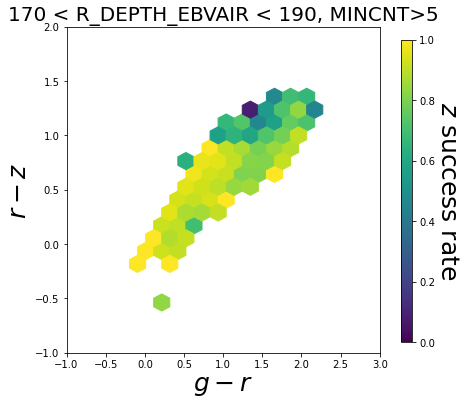

In [10]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
hb = sub.hexbin(g_mags - r_mags, r_mags - z_mags, C=zss.astype(float), reduce_C_function=np.mean, gridsize=50, vmin=0., vmax=1., mincnt=5)
sub.set_xlabel('$g - r$', fontsize=25)
sub.set_xlim(-1, 3)
sub.set_ylabel('$r - z$', fontsize=25)
sub.set_ylim(-1, 2)
sub.set_title("%.f < R_DEPTH_EBVAIR < %.f, MINCNT>5" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)
fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)

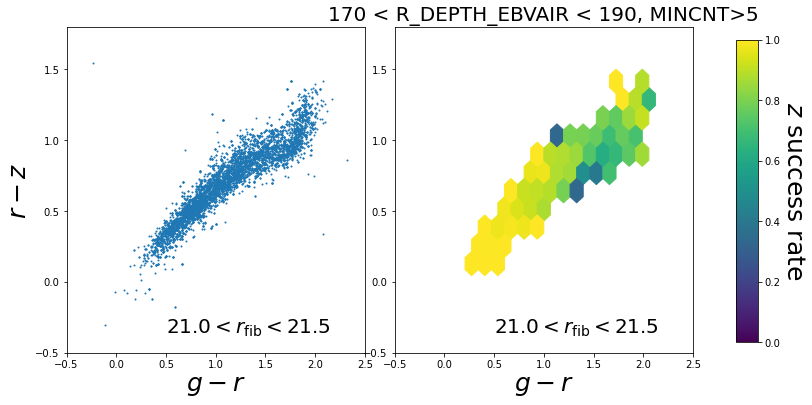

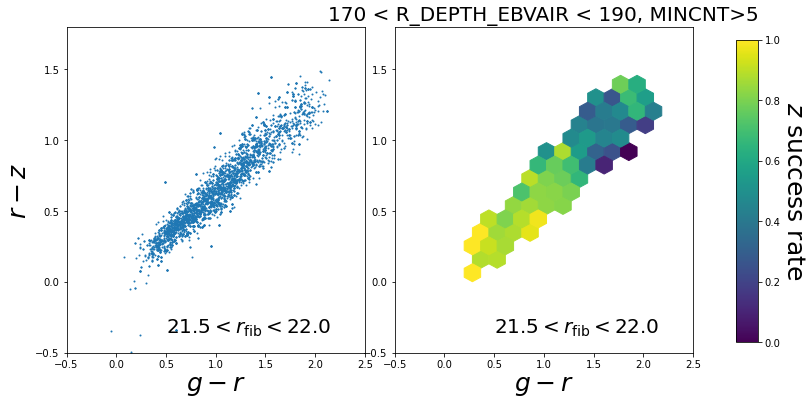

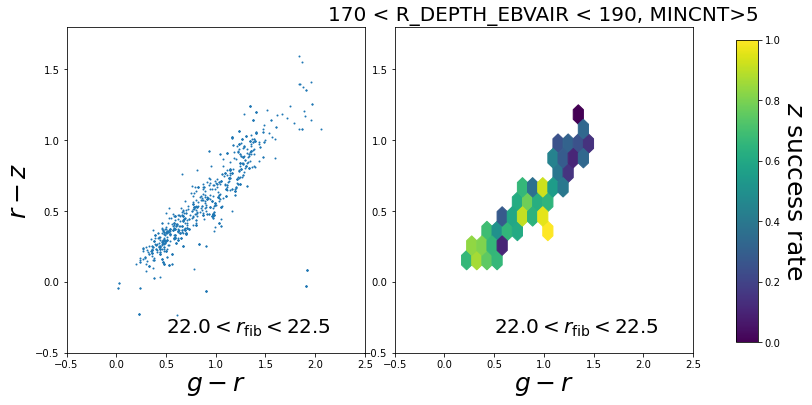

In [11]:
for r_fibmag_low, r_fibmag_high in zip([21., 21.5, 22.], [21.5, 22., 22.5]): 
    rfiblim = (r_fibmags > r_fibmag_low) & (r_fibmags < r_fibmag_high)
    gr = (g_mags - r_mags)[rfiblim]
    rz = (r_mags - z_mags)[rfiblim]
    
    fig = plt.figure(figsize=(12,6))
    sub = fig.add_subplot(121)
    sub.scatter(gr, rz, c='C0', s=1)
    sub.text(0.5, -0.25, r'$%.1f < r_{\rm fib} < %.1f$' % (r_fibmag_low, r_fibmag_high), ha='left', va='top', fontsize=20)
    sub.set_xlabel('$g - r$', fontsize=25)
    sub.set_xlim(-0.5, 2.5)
    sub.set_ylabel('$r - z$', fontsize=25)
    sub.set_ylim(-0.5, 1.8)
    
    sub = fig.add_subplot(122)
    hb = sub.hexbin(gr, rz, C=zss[rfiblim].astype(float), reduce_C_function=np.mean, gridsize=20, vmin=0., vmax=1., mincnt=5)
    sub.text(0.5, -0.25, r'$%.1f < r_{\rm fib} < %.1f$' % (r_fibmag_low, r_fibmag_high), ha='left', va='top', fontsize=20)
    sub.set_xlabel('$g - r$', fontsize=25)
    sub.set_xlim(-0.5, 2.5)
    sub.set_ylim(-0.5, 1.8)
    sub.set_title("%.f < R_DEPTH_EBVAIR < %.f, MINCNT>5" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)
    fig.subplots_adjust(wspace=0.1, right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)

In [12]:
schlegel_color = (z_mags - w1_mags) - 3/2.5 * (g_mags - r_mags) + 1.2

Text(0, 0.5, '$z$ success rate')

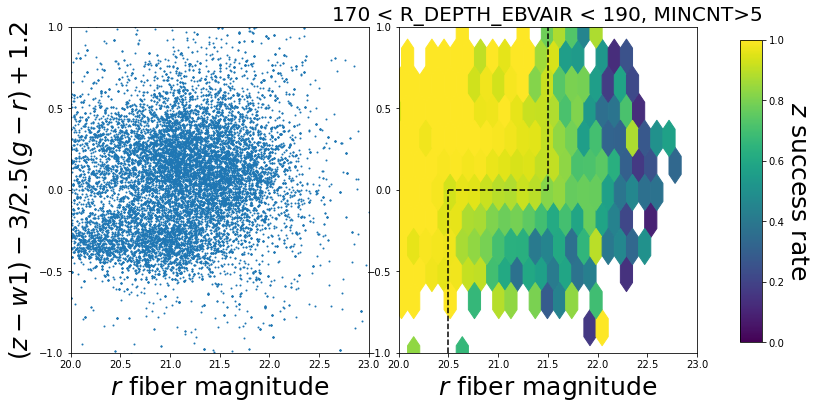

In [15]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(r_fibmags, schlegel_color, c='C0', s=1)
sub.set_ylabel('$(z - w1) - 3/2.5 (g - r) + 1.2$', fontsize=25)
sub.set_yticks([-1., -0.5, 0., 0.5, 1.])
sub.set_ylim(-1, 1.)
sub.set_xlabel('$r$ fiber magnitude', fontsize=25)
sub.set_xlim(20, 23)

sub = fig.add_subplot(122)
hb = sub.hexbin(r_fibmags, schlegel_color, C=zss.astype(float), reduce_C_function=np.mean, gridsize=80, vmin=0., vmax=1., mincnt=5)
sub.plot([20.5, 20.5], [-1, 0.], c='k', ls='--')
sub.plot([20.5, 21.5], [0., 0.], c='k', ls='--')
sub.plot([21.5, 21.5], [0., 1.], c='k', ls='--')
sub.set_yticks([-1., -0.5, 0., 0.5, 1.])
sub.set_ylim(-1, 1.)
sub.set_xlabel('$r$ fiber magnitude', fontsize=25)
sub.set_xlim(20, 23)
sub.set_title("%.f < R_DEPTH_EBVAIR < %.f, MINCNT>5" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)
fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)

Text(0, 0.5, 'number of targets $< r_{\\rm fib}$ in 11 tiles')

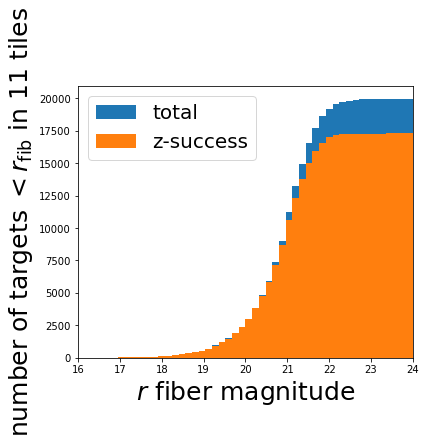

In [14]:
fig = plt.figure(figsize=(6,5))
sub = fig.add_subplot(111)
sub.hist(r_fibmags, range=(16, 24), bins=50, cumulative=True, label='total')
sub.hist(r_fibmags[zss], range=(16, 24), bins=50, cumulative=True, label='z-success')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('$r$ fiber magnitude', fontsize=25)
sub.set_xlim(16,24)
sub.set_ylabel(r'number of targets $< r_{\rm fib}$ in %i tiles' % np.sum(keep & close_to_nominal), fontsize=25)